In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline

In [2]:
df = pd.read_csv("data/Fraud.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [6]:
df.shape

(6362620, 11)

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
pd.set_option("display.float_format", "{:.2f}".format)

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [11]:
df.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


In [12]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [13]:
sdf = df[["type", "isFraud", "isFlaggedFraud"]].copy()
sdf["isFraud"] = sdf["isFraud"].astype(object)
sdf["isFlaggedFraud"] = sdf["isFlaggedFraud"].astype(object)

sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
dtypes: object(3)
memory usage: 145.6+ MB


In [14]:
sdf.groupby("type").describe(include="all")

isFraud                     isFlaggedFraud                    
            count unique top     freq          count unique top     freq
type                                                                    
CASH_IN   1399284      1   0  1399284        1399284      1   0  1399284
CASH_OUT  2237500      2   0  2233384        2237500      1   0  2237500
DEBIT       41432      1   0    41432          41432      1   0    41432
PAYMENT   2151495      1   0  2151495        2151495      1   0  2151495
TRANSFER   532909      2   0   528812         532909      2   0   532893

In [15]:
from scipy.stats import chi2_contingency

contingency_nameOrig = pd.crosstab(df["nameOrig"], df["isFraud"])
contingency_nameDest = pd.crosstab(df["nameDest"], df["isFraud"])

In [16]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameOrig)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameOrig and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.")

Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.


In [17]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameDest)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameDest and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameDest and isFraud.")

Reject the null hypothesis: There is a significant association between nameDest and isFraud.


In [18]:
df.drop("nameOrig", axis=1, inplace=True)

In [19]:
nameDest_val_counts = df["nameDest"].value_counts()
frequent_vals = nameDest_val_counts[nameDest_val_counts > 1].index
df["dest_group"] = df["nameDest"].where(df["nameDest"].isin(frequent_vals), "other")
len(df["dest_group"].unique())

459659

In [20]:
df.drop("nameDest", axis=1, inplace=True)

In [21]:
sdf["dest_group"] = df["dest_group"].astype(object)
sdf.head()

,type,isFraud,isFlaggedFraud,dest_group
0,PAYMENT,0,0,other
1,PAYMENT,0,0,other
2,TRANSFER,1,0,C553264065
3,CASH_OUT,1,0,C38997010
4,PAYMENT,0,0,other


In [22]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_group
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,other
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,other
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,C553264065
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,C38997010
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,other


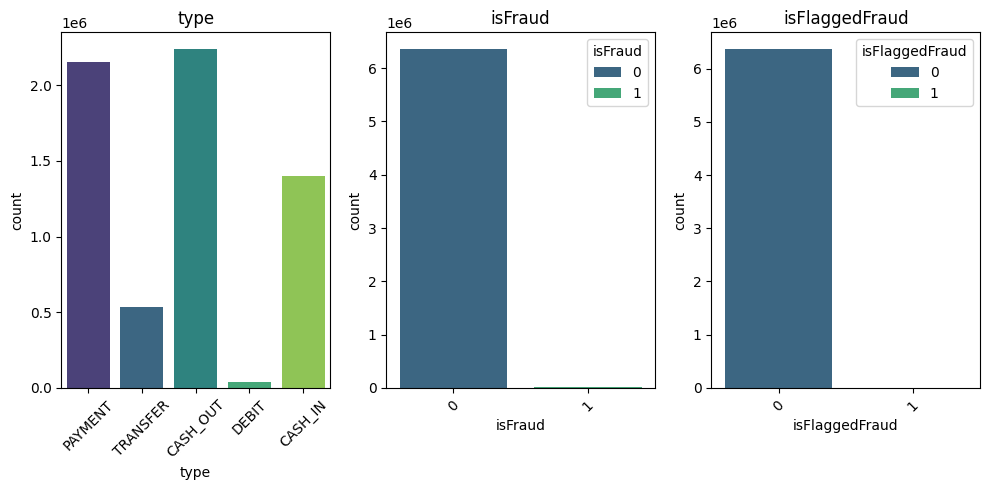

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, col in enumerate(["type", "isFraud", "isFlaggedFraud"]):
    sns.countplot(x=col, hue=col, data=sdf, ax=axes[i], palette="viridis")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", labelrotation=45)

plt.tight_layout()

In [24]:
numerical_vals = df.select_dtypes(include=["int32", "int64", "float64"]).columns.tolist()

num_vals_stats = [val for val in numerical_vals if val not in {"isFraud", "isFlaggedFraud"}]

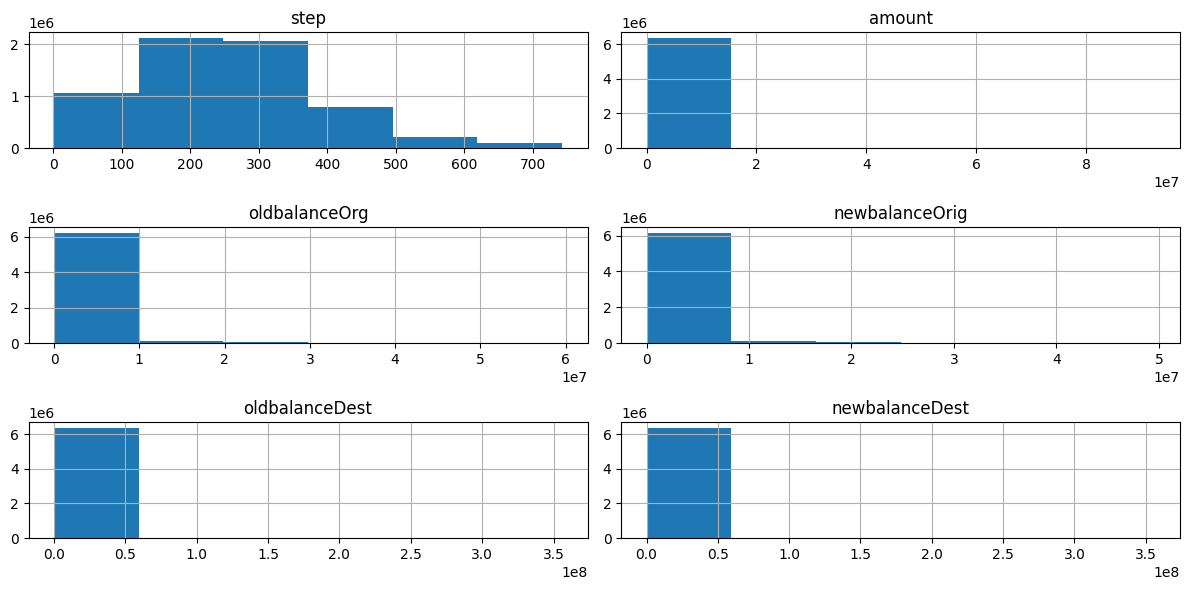

In [25]:
df[num_vals_stats].hist(figsize=(12, 6), layout=(3, 2), bins=6)
plt.tight_layout()

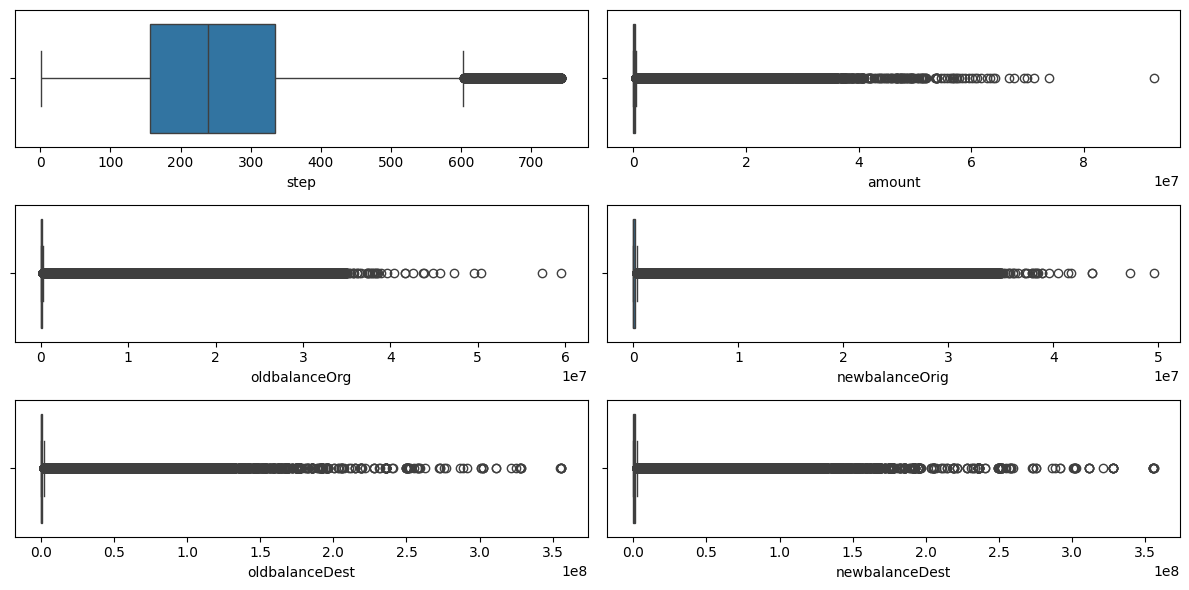

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.boxplot(data=df, x=col, ax=axes.flat[i])

plt.tight_layout()


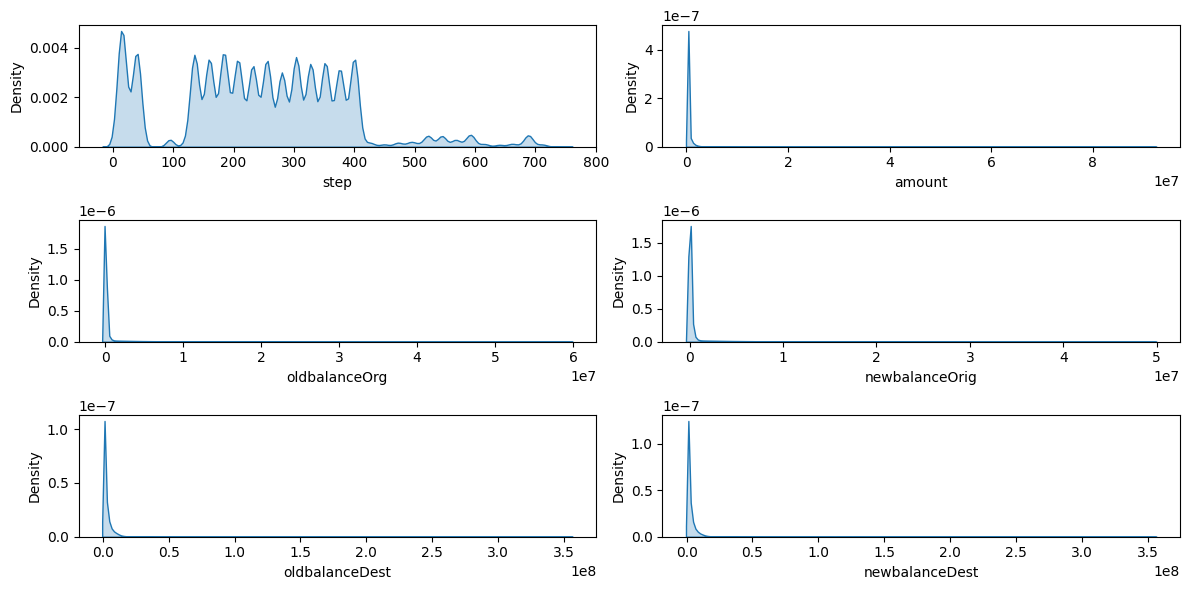

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.kdeplot(data=df, x=col, ax=axes.flat[i], fill=True)
    
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

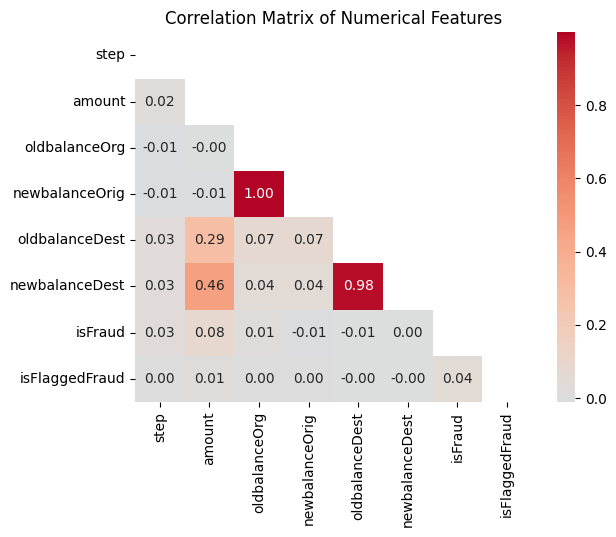

In [28]:
corr = df[numerical_vals].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Numerical Features")

In [29]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
 3   dest_group      object
dtypes: object(4)
memory usage: 194.2+ MB


In [30]:
contingency_type = pd.crosstab(sdf["type"], sdf["isFraud"])

statistic, p_value, dof, expected = chi2_contingency(contingency_type)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between type and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between type and isFraud.")

Reject the null hypothesis: There is a significant association between type and isFraud.


In [31]:
types = pd.get_dummies(data=sdf["type"], prefix="type", dtype="int32")

types.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [32]:
sdf = pd.concat([sdf, types], axis=1)

sdf.drop("type", axis=1, inplace=True)
sdf.head()

,isFraud,isFlaggedFraud,dest_group,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,other,0,0,0,1,0
1,0,0,other,0,0,0,1,0
2,1,0,C553264065,0,0,0,0,1
3,1,0,C38997010,0,1,0,0,0
4,0,0,other,0,0,0,1,0


Text(0.5, 1.0, 'Correlation Matrix of Categorical Features')

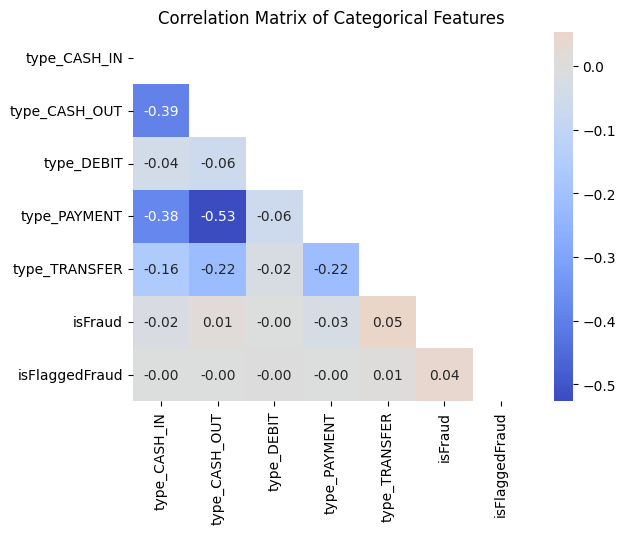

In [33]:
corr = sdf[types.columns.to_list() + ["isFraud", "isFlaggedFraud"]].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Categorical Features")

In [34]:
df.groupby(by=["isFraud", "type"])["amount"].count()

isFraud  type    
0        CASH_IN     1399284
         CASH_OUT    2233384
         DEBIT         41432
         PAYMENT     2151495
         TRANSFER     528812
1        CASH_OUT       4116
         TRANSFER       4097
Name: amount, dtype: int64

In [35]:
df.groupby("isFraud")["amount"].count()

isFraud
0    6354407
1       8213
Name: amount, dtype: int64

In [36]:
y = df["isFraud"]
X = df.drop(columns=["isFraud"])

In [37]:
X["type"] = X["type"].astype("category")
X["dest_group"] = X["dest_group"].astype("category")

In [38]:
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [39]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
numerical_vars = X_train.select_dtypes(include="number").columns.tolist()

In [42]:
preprocess = ColumnTransformer(
    transformers=[
        ("numerical_vars", StandardScaler(), numerical_vars),
        ("categorical_vars_type", OneHotEncoder(handle_unknown="ignore"), ["type"]),
        ("categorical_vars_dest_group", TargetEncoder(), ["dest_group"]),
    ],
    remainder="passthrough",
)

In [43]:
preprocess

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical_vars', StandardScaler(),
                                 ['step', 'amount', 'oldbalanceOrg',
                                  'newbalanceOrig', 'oldbalanceDest',
                                  'newbalanceDest', 'isFlaggedFraud']),
                                ('categorical_vars_type',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type']),
                                ('categorical_vars_dest_group', TargetEncoder(),
                                 ['dest_group'])])

In [44]:
X_train_transformed = preprocess.fit_transform(X_train, y_train)

In [45]:
feature_names = preprocess.get_feature_names_out()

In [46]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform("gamma", 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 40, 180),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": 180,
    "seed": 0
}

In [47]:
X_test_transformed = preprocess.transform(X_test)

In [50]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

def objective(space):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        eval_metric="aucpr",
        use_label_encoder=False,
        random_state=42,
        n_estimators=space["n_estimators"],
        learning_rate=0.1,
        max_depth=int(space["max_depth"]),
        gamma=space["gamma"],
        reg_alpha=space["reg_alpha"],
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"])
    )

    model.fit(X_train_transformed, y_train, eval_set=[(X_test_transformed, y_test)], verbose=True)
    y_pred = model.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")

    return {'loss': log_loss(y_test, y_pred), 'status': STATUS_OK }

In [51]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:45:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54404                         
[1]	validation_0-aucpr:0.69119                         
[2]	validation_0-aucpr:0.66769                         
[3]	validation_0-aucpr:0.67020                         
[4]	validation_0-aucpr:0.65753                         
[5]	validation_0-aucpr:0.87126                         
[6]	validation_0-aucpr:0.87934                         
[7]	validation_0-aucpr:0.88157                         
[8]	validation_0-aucpr:0.88364                         
[9]	validation_0-aucpr:0.88480                         
[10]	validation_0-aucpr:0.88804                        
[11]	validation_0-aucpr:0.89356                        
[12]	validation_0-aucpr:0.89666                        
[13]	validation_0-aucpr:0.89916                        
[14]	validation_0-aucpr:0.90035                        
[15]	validation_0-aucpr:0.89994                        
[16]	validation_0-aucpr:0.89993                        
[17]	validation_0-aucpr:0.89932                 

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:46:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.01544                                                      
[1]	validation_0-aucpr:0.06292                                                      
[2]	validation_0-aucpr:0.08939                                                      
[3]	validation_0-aucpr:0.08977                                                      
[4]	validation_0-aucpr:0.08982                                                      
[5]	validation_0-aucpr:0.43606                                                      
[6]	validation_0-aucpr:0.43620                                                      
[7]	validation_0-aucpr:0.49542                                                      
[8]	validation_0-aucpr:0.49589                                                      
[9]	validation_0-aucpr:0.50480                                                      
[10]	validation_0-aucpr:0.50746                                                     
[11]	validation_0-aucpr:0.50527                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.03533                                                      
[1]	validation_0-aucpr:0.19889                                                      
[2]	validation_0-aucpr:0.30717                                                      
[3]	validation_0-aucpr:0.45792                                                      
[4]	validation_0-aucpr:0.72216                                                      
[5]	validation_0-aucpr:0.72540                                                      
[6]	validation_0-aucpr:0.71547                                                      
[7]	validation_0-aucpr:0.71544                                                      
[8]	validation_0-aucpr:0.72950                                                      
[9]	validation_0-aucpr:0.74320                                                      
[10]	validation_0-aucpr:0.74055                                                     
[11]	validation_0-aucpr:0.73854                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:48:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.28488                                                      
[1]	validation_0-aucpr:0.44911                                                      
[2]	validation_0-aucpr:0.67836                                                      
[3]	validation_0-aucpr:0.73520                                                      
[4]	validation_0-aucpr:0.85769                                                      
[5]	validation_0-aucpr:0.84970                                                      
[6]	validation_0-aucpr:0.84015                                                      
[7]	validation_0-aucpr:0.86200                                                      
[8]	validation_0-aucpr:0.86253                                                      
[9]	validation_0-aucpr:0.87711                                                      
[10]	validation_0-aucpr:0.88712                                                     
[11]	validation_0-aucpr:0.88253                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:49:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.18379                                                      
[1]	validation_0-aucpr:0.48539                                                      
[2]	validation_0-aucpr:0.47741                                                      
[3]	validation_0-aucpr:0.53295                                                      
[4]	validation_0-aucpr:0.53345                                                      
[5]	validation_0-aucpr:0.83991                                                      
[6]	validation_0-aucpr:0.84532                                                      
[7]	validation_0-aucpr:0.87235                                                      
[8]	validation_0-aucpr:0.87521                                                      
[9]	validation_0-aucpr:0.87542                                                      
[10]	validation_0-aucpr:0.87257                                                     
[11]	validation_0-aucpr:0.87067                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:50:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.11899                                                      
[1]	validation_0-aucpr:0.33978                                                      
[2]	validation_0-aucpr:0.37190                                                      
[3]	validation_0-aucpr:0.37053                                                      
[4]	validation_0-aucpr:0.37720                                                      
[5]	validation_0-aucpr:0.77074                                                      
[6]	validation_0-aucpr:0.78918                                                      
[7]	validation_0-aucpr:0.83206                                                      
[8]	validation_0-aucpr:0.83116                                                      
[9]	validation_0-aucpr:0.82850                                                      
[10]	validation_0-aucpr:0.82666                                                     
[11]	validation_0-aucpr:0.82240                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:50:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.59304                                                      
[1]	validation_0-aucpr:0.72924                                                      
[2]	validation_0-aucpr:0.72758                                                      
[3]	validation_0-aucpr:0.72940                                                      
[4]	validation_0-aucpr:0.72578                                                      
[5]	validation_0-aucpr:0.86983                                                      
[6]	validation_0-aucpr:0.90114                                                      
[7]	validation_0-aucpr:0.90383                                                      
[8]	validation_0-aucpr:0.90631                                                      
[9]	validation_0-aucpr:0.90509                                                      
[10]	validation_0-aucpr:0.90654                                                     
[11]	validation_0-aucpr:0.90635                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:51:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42009                                                      
[1]	validation_0-aucpr:0.57827                                                      
[2]	validation_0-aucpr:0.58851                                                      
[3]	validation_0-aucpr:0.61455                                                      
[4]	validation_0-aucpr:0.63181                                                      
[5]	validation_0-aucpr:0.88019                                                      
[6]	validation_0-aucpr:0.88191                                                      
[7]	validation_0-aucpr:0.90881                                                      
[8]	validation_0-aucpr:0.91135                                                      
[9]	validation_0-aucpr:0.91297                                                      
[10]	validation_0-aucpr:0.91892                                                     
[11]	validation_0-aucpr:0.91579                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:52:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.01544                                                      
[1]	validation_0-aucpr:0.06292                                                      
[2]	validation_0-aucpr:0.08939                                                      
[3]	validation_0-aucpr:0.08938                                                      
[4]	validation_0-aucpr:0.08946                                                      
[5]	validation_0-aucpr:0.43543                                                      
[6]	validation_0-aucpr:0.46138                                                      
[7]	validation_0-aucpr:0.45573                                                      
[8]	validation_0-aucpr:0.44048                                                      
[9]	validation_0-aucpr:0.41413                                                      
[10]	validation_0-aucpr:0.41371                                                     
[11]	validation_0-aucpr:0.44983                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.30787                                                      
[1]	validation_0-aucpr:0.62379                                                      
[2]	validation_0-aucpr:0.63699                                                      
[3]	validation_0-aucpr:0.68456                                                      
[4]	validation_0-aucpr:0.72526                                                      
[5]	validation_0-aucpr:0.86508                                                      
[6]	validation_0-aucpr:0.86713                                                      
[7]	validation_0-aucpr:0.89511                                                      
[8]	validation_0-aucpr:0.89427                                                      
[9]	validation_0-aucpr:0.89899                                                      
[10]	validation_0-aucpr:0.91202                                                     
[11]	validation_0-aucpr:0.90803                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:54:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.20497                                                       
[1]	validation_0-aucpr:0.54434                                                       
[2]	validation_0-aucpr:0.54537                                                       
[3]	validation_0-aucpr:0.56849                                                       
[4]	validation_0-aucpr:0.56743                                                       
[5]	validation_0-aucpr:0.79508                                                       
[6]	validation_0-aucpr:0.81631                                                       
[7]	validation_0-aucpr:0.82898                                                       
[8]	validation_0-aucpr:0.83849                                                       
[9]	validation_0-aucpr:0.84015                                                       
[10]	validation_0-aucpr:0.84067                                                      
[11]	validation_0-aucpr:0.82534                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:55:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.37797                                                       
[1]	validation_0-aucpr:0.55076                                                       
[2]	validation_0-aucpr:0.55811                                                       
[3]	validation_0-aucpr:0.58528                                                       
[4]	validation_0-aucpr:0.59824                                                       
[5]	validation_0-aucpr:0.87401                                                       
[6]	validation_0-aucpr:0.87739                                                       
[7]	validation_0-aucpr:0.90414                                                       
[8]	validation_0-aucpr:0.90463                                                       
[9]	validation_0-aucpr:0.90709                                                       
[10]	validation_0-aucpr:0.91047                                                      
[11]	validation_0-aucpr:0.90580                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:56:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54359                                                       
[1]	validation_0-aucpr:0.69334                                                       
[2]	validation_0-aucpr:0.67011                                                       
[3]	validation_0-aucpr:0.65773                                                       
[4]	validation_0-aucpr:0.65830                                                       
[5]	validation_0-aucpr:0.87469                                                       
[6]	validation_0-aucpr:0.88139                                                       
[7]	validation_0-aucpr:0.88271                                                       
[8]	validation_0-aucpr:0.88893                                                       
[9]	validation_0-aucpr:0.89189                                                       
[10]	validation_0-aucpr:0.89738                                                      
[11]	validation_0-aucpr:0.89984                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:57:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34624                                                       
[1]	validation_0-aucpr:0.47272                                                       
[2]	validation_0-aucpr:0.60735                                                       
[3]	validation_0-aucpr:0.70589                                                       
[4]	validation_0-aucpr:0.85703                                                       
[5]	validation_0-aucpr:0.86389                                                       
[6]	validation_0-aucpr:0.83926                                                       
[7]	validation_0-aucpr:0.86398                                                       
[8]	validation_0-aucpr:0.86375                                                       
[9]	validation_0-aucpr:0.87474                                                       
[10]	validation_0-aucpr:0.88348                                                      
[11]	validation_0-aucpr:0.87531                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:58:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50757                                                       
[1]	validation_0-aucpr:0.65569                                                       
[2]	validation_0-aucpr:0.61713                                                       
[3]	validation_0-aucpr:0.63034                                                       
[4]	validation_0-aucpr:0.64763                                                       
[5]	validation_0-aucpr:0.86339                                                       
[6]	validation_0-aucpr:0.87157                                                       
[7]	validation_0-aucpr:0.88873                                                       
[8]	validation_0-aucpr:0.89564                                                       
[9]	validation_0-aucpr:0.89730                                                       
[10]	validation_0-aucpr:0.90481                                                      
[11]	validation_0-aucpr:0.90491                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:59:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53011                                                       
[1]	validation_0-aucpr:0.68233                                                       
[2]	validation_0-aucpr:0.70344                                                       
[3]	validation_0-aucpr:0.70514                                                       
[4]	validation_0-aucpr:0.70662                                                       
[5]	validation_0-aucpr:0.87755                                                       
[6]	validation_0-aucpr:0.90081                                                       
[7]	validation_0-aucpr:0.91350                                                       
[8]	validation_0-aucpr:0.91927                                                       
[9]	validation_0-aucpr:0.91864                                                       
[10]	validation_0-aucpr:0.91888                                                      
[11]	validation_0-aucpr:0.91518                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.28491                                                       
[1]	validation_0-aucpr:0.44924                                                       
[2]	validation_0-aucpr:0.69038                                                       
[3]	validation_0-aucpr:0.75200                                                       
[4]	validation_0-aucpr:0.85920                                                       
[5]	validation_0-aucpr:0.85145                                                       
[6]	validation_0-aucpr:0.84053                                                       
[7]	validation_0-aucpr:0.86183                                                       
[8]	validation_0-aucpr:0.86286                                                       
[9]	validation_0-aucpr:0.87714                                                       
[10]	validation_0-aucpr:0.88711                                                      
[11]	validation_0-aucpr:0.88238                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:01:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42065                                                       
[1]	validation_0-aucpr:0.58100                                                       
[2]	validation_0-aucpr:0.60142                                                       
[3]	validation_0-aucpr:0.64091                                                       
[4]	validation_0-aucpr:0.65912                                                       
[5]	validation_0-aucpr:0.88361                                                       
[6]	validation_0-aucpr:0.88900                                                       
[7]	validation_0-aucpr:0.91529                                                       
[8]	validation_0-aucpr:0.91777                                                       
[9]	validation_0-aucpr:0.91876                                                       
[10]	validation_0-aucpr:0.92453                                                      
[11]	validation_0-aucpr:0.92201                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:02:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41364                                                       
[1]	validation_0-aucpr:0.58287                                                       
[2]	validation_0-aucpr:0.59105                                                       
[3]	validation_0-aucpr:0.62934                                                       
[4]	validation_0-aucpr:0.63303                                                       
[5]	validation_0-aucpr:0.88460                                                       
[6]	validation_0-aucpr:0.89155                                                       
[7]	validation_0-aucpr:0.91439                                                       
[8]	validation_0-aucpr:0.91607                                                       
[9]	validation_0-aucpr:0.91886                                                       
[10]	validation_0-aucpr:0.92336                                                      
[11]	validation_0-aucpr:0.92114                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.52994                                                       
[1]	validation_0-aucpr:0.69392                                                       
[2]	validation_0-aucpr:0.69488                                                       
[3]	validation_0-aucpr:0.68540                                                       
[4]	validation_0-aucpr:0.69540                                                       
[5]	validation_0-aucpr:0.86511                                                       
[6]	validation_0-aucpr:0.89350                                                       
[7]	validation_0-aucpr:0.90588                                                       
[8]	validation_0-aucpr:0.90877                                                       
[9]	validation_0-aucpr:0.91164                                                       
[10]	validation_0-aucpr:0.91140                                                      
[11]	validation_0-aucpr:0.91370                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:04:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36447                                                       
[1]	validation_0-aucpr:0.59985                                                       
[2]	validation_0-aucpr:0.79161                                                       
[3]	validation_0-aucpr:0.83708                                                       
[4]	validation_0-aucpr:0.85821                                                       
[5]	validation_0-aucpr:0.88684                                                       
[6]	validation_0-aucpr:0.87544                                                       
[7]	validation_0-aucpr:0.90178                                                       
[8]	validation_0-aucpr:0.90080                                                       
[9]	validation_0-aucpr:0.90596                                                       
[10]	validation_0-aucpr:0.91710                                                      
[11]	validation_0-aucpr:0.91465                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:05:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54547                                                       
[1]	validation_0-aucpr:0.69676                                                       
[2]	validation_0-aucpr:0.67310                                                       
[3]	validation_0-aucpr:0.65871                                                       
[4]	validation_0-aucpr:0.66263                                                       
[5]	validation_0-aucpr:0.87618                                                       
[6]	validation_0-aucpr:0.88021                                                       
[7]	validation_0-aucpr:0.88492                                                       
[8]	validation_0-aucpr:0.88913                                                       
[9]	validation_0-aucpr:0.89050                                                       
[10]	validation_0-aucpr:0.89407                                                      
[11]	validation_0-aucpr:0.89761                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:06:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.61559                                                       
[1]	validation_0-aucpr:0.75210                                                       
[2]	validation_0-aucpr:0.70023                                                       
[3]	validation_0-aucpr:0.66046                                                       
[4]	validation_0-aucpr:0.66355                                                       
[5]	validation_0-aucpr:0.87919                                                       
[6]	validation_0-aucpr:0.88646                                                       
[7]	validation_0-aucpr:0.88976                                                       
[8]	validation_0-aucpr:0.89576                                                       
[9]	validation_0-aucpr:0.89786                                                       
[10]	validation_0-aucpr:0.90184                                                      
[11]	validation_0-aucpr:0.90454                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:07:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36413                                                       
[1]	validation_0-aucpr:0.60127                                                       
[2]	validation_0-aucpr:0.78308                                                       
[3]	validation_0-aucpr:0.83114                                                       
[4]	validation_0-aucpr:0.84864                                                       
[5]	validation_0-aucpr:0.88083                                                       
[6]	validation_0-aucpr:0.86905                                                       
[7]	validation_0-aucpr:0.89915                                                       
[8]	validation_0-aucpr:0.89722                                                       
[9]	validation_0-aucpr:0.89933                                                       
[10]	validation_0-aucpr:0.91196                                                      
[11]	validation_0-aucpr:0.91052                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:08:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63703                                                       
[1]	validation_0-aucpr:0.72392                                                       
[2]	validation_0-aucpr:0.68897                                                       
[3]	validation_0-aucpr:0.66541                                                       
[4]	validation_0-aucpr:0.66678                                                       
[5]	validation_0-aucpr:0.88505                                                       
[6]	validation_0-aucpr:0.89106                                                       
[7]	validation_0-aucpr:0.91175                                                       
[8]	validation_0-aucpr:0.91514                                                       
[9]	validation_0-aucpr:0.91698                                                       
[10]	validation_0-aucpr:0.91859                                                      
[11]	validation_0-aucpr:0.92073                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:09:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36821                                                       
[1]	validation_0-aucpr:0.74784                                                       
[2]	validation_0-aucpr:0.82711                                                       
[3]	validation_0-aucpr:0.86534                                                       
[4]	validation_0-aucpr:0.86421                                                       
[5]	validation_0-aucpr:0.88906                                                       
[6]	validation_0-aucpr:0.87384                                                       
[7]	validation_0-aucpr:0.90168                                                       
[8]	validation_0-aucpr:0.89965                                                       
[9]	validation_0-aucpr:0.90777                                                       
[10]	validation_0-aucpr:0.91855                                                      
[11]	validation_0-aucpr:0.91649                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:10:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36889                                                       
[1]	validation_0-aucpr:0.74825                                                       
[2]	validation_0-aucpr:0.82795                                                       
[3]	validation_0-aucpr:0.87051                                                       
[4]	validation_0-aucpr:0.86888                                                       
[5]	validation_0-aucpr:0.89114                                                       
[6]	validation_0-aucpr:0.87602                                                       
[7]	validation_0-aucpr:0.90398                                                       
[8]	validation_0-aucpr:0.90163                                                       
[9]	validation_0-aucpr:0.91093                                                       
[10]	validation_0-aucpr:0.92147                                                      
[11]	validation_0-aucpr:0.92052                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:11:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34381                                                       
[1]	validation_0-aucpr:0.55984                                                       
[2]	validation_0-aucpr:0.73102                                                       
[3]	validation_0-aucpr:0.80806                                                       
[4]	validation_0-aucpr:0.88573                                                       
[5]	validation_0-aucpr:0.87521                                                       
[6]	validation_0-aucpr:0.86417                                                       
[7]	validation_0-aucpr:0.88189                                                       
[8]	validation_0-aucpr:0.88537                                                       
[9]	validation_0-aucpr:0.89646                                                       
[10]	validation_0-aucpr:0.90636                                                      
[11]	validation_0-aucpr:0.90262                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:12:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36852                                                       
[1]	validation_0-aucpr:0.74779                                                       
[2]	validation_0-aucpr:0.82620                                                       
[3]	validation_0-aucpr:0.86312                                                       
[4]	validation_0-aucpr:0.86437                                                       
[5]	validation_0-aucpr:0.88803                                                       
[6]	validation_0-aucpr:0.87404                                                       
[7]	validation_0-aucpr:0.90099                                                       
[8]	validation_0-aucpr:0.89906                                                       
[9]	validation_0-aucpr:0.90814                                                       
[10]	validation_0-aucpr:0.91874                                                      
[11]	validation_0-aucpr:0.91600                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:13:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36719                                                       
[1]	validation_0-aucpr:0.60484                                                       
[2]	validation_0-aucpr:0.79687                                                       
[3]	validation_0-aucpr:0.84060                                                       
[4]	validation_0-aucpr:0.85612                                                       
[5]	validation_0-aucpr:0.88424                                                       
[6]	validation_0-aucpr:0.87202                                                       
[7]	validation_0-aucpr:0.90010                                                       
[8]	validation_0-aucpr:0.89885                                                       
[9]	validation_0-aucpr:0.90547                                                       
[10]	validation_0-aucpr:0.91613                                                      
[11]	validation_0-aucpr:0.91293                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:14:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42160                                                       
[1]	validation_0-aucpr:0.59132                                                       
[2]	validation_0-aucpr:0.59993                                                       
[3]	validation_0-aucpr:0.63913                                                       
[4]	validation_0-aucpr:0.64157                                                       
[5]	validation_0-aucpr:0.89392                                                       
[6]	validation_0-aucpr:0.89677                                                       
[7]	validation_0-aucpr:0.91810                                                       
[8]	validation_0-aucpr:0.91990                                                       
[9]	validation_0-aucpr:0.92274                                                       
[10]	validation_0-aucpr:0.92985                                                      
[11]	validation_0-aucpr:0.92700                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34345                                                       
[1]	validation_0-aucpr:0.54587                                                       
[2]	validation_0-aucpr:0.73471                                                       
[3]	validation_0-aucpr:0.80147                                                       
[4]	validation_0-aucpr:0.88274                                                       
[5]	validation_0-aucpr:0.87316                                                       
[6]	validation_0-aucpr:0.85680                                                       
[7]	validation_0-aucpr:0.87508                                                       
[8]	validation_0-aucpr:0.87812                                                       
[9]	validation_0-aucpr:0.88948                                                       
[10]	validation_0-aucpr:0.89898                                                      
[11]	validation_0-aucpr:0.89643                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:16:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35779                                                       
[1]	validation_0-aucpr:0.47527                                                       
[2]	validation_0-aucpr:0.61550                                                       
[3]	validation_0-aucpr:0.71317                                                       
[4]	validation_0-aucpr:0.86682                                                       
[5]	validation_0-aucpr:0.87205                                                       
[6]	validation_0-aucpr:0.84972                                                       
[7]	validation_0-aucpr:0.87325                                                       
[8]	validation_0-aucpr:0.87309                                                       
[9]	validation_0-aucpr:0.88381                                                       
[10]	validation_0-aucpr:0.89257                                                      
[11]	validation_0-aucpr:0.88543                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.28761                                                       
[1]	validation_0-aucpr:0.45078                                                       
[2]	validation_0-aucpr:0.69500                                                       
[3]	validation_0-aucpr:0.76326                                                       
[4]	validation_0-aucpr:0.86453                                                       
[5]	validation_0-aucpr:0.85458                                                       
[6]	validation_0-aucpr:0.84230                                                       
[7]	validation_0-aucpr:0.86355                                                       
[8]	validation_0-aucpr:0.86400                                                       
[9]	validation_0-aucpr:0.87361                                                       
[10]	validation_0-aucpr:0.88486                                                      
[11]	validation_0-aucpr:0.88090                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36006                                                       
[1]	validation_0-aucpr:0.62562                                                       
[2]	validation_0-aucpr:0.65905                                                       
[3]	validation_0-aucpr:0.71833                                                       
[4]	validation_0-aucpr:0.75981                                                       
[5]	validation_0-aucpr:0.87273                                                       
[6]	validation_0-aucpr:0.86576                                                       
[7]	validation_0-aucpr:0.89465                                                       
[8]	validation_0-aucpr:0.89441                                                       
[9]	validation_0-aucpr:0.89681                                                       
[10]	validation_0-aucpr:0.90953                                                      
[11]	validation_0-aucpr:0.90668                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:19:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34250                                                       
[1]	validation_0-aucpr:0.55843                                                       
[2]	validation_0-aucpr:0.71722                                                       
[3]	validation_0-aucpr:0.79521                                                       
[4]	validation_0-aucpr:0.88118                                                       
[5]	validation_0-aucpr:0.86944                                                       
[6]	validation_0-aucpr:0.85576                                                       
[7]	validation_0-aucpr:0.87440                                                       
[8]	validation_0-aucpr:0.87885                                                       
[9]	validation_0-aucpr:0.89145                                                       
[10]	validation_0-aucpr:0.90135                                                      
[11]	validation_0-aucpr:0.89915                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:20:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63723                                                       
[1]	validation_0-aucpr:0.75083                                                       
[2]	validation_0-aucpr:0.69154                                                       
[3]	validation_0-aucpr:0.63576                                                       
[4]	validation_0-aucpr:0.64502                                                       
[5]	validation_0-aucpr:0.87174                                                       
[6]	validation_0-aucpr:0.87804                                                       
[7]	validation_0-aucpr:0.90069                                                       
[8]	validation_0-aucpr:0.90648                                                       
[9]	validation_0-aucpr:0.91242                                                       
[10]	validation_0-aucpr:0.92086                                                      
[11]	validation_0-aucpr:0.92623                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:21:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34504                                                       
[1]	validation_0-aucpr:0.56190                                                       
[2]	validation_0-aucpr:0.72797                                                       
[3]	validation_0-aucpr:0.80392                                                       
[4]	validation_0-aucpr:0.88560                                                       
[5]	validation_0-aucpr:0.87506                                                       
[6]	validation_0-aucpr:0.86135                                                       
[7]	validation_0-aucpr:0.87803                                                       
[8]	validation_0-aucpr:0.88141                                                       
[9]	validation_0-aucpr:0.89266                                                       
[10]	validation_0-aucpr:0.90262                                                      
[11]	validation_0-aucpr:0.89962                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41974                                                       
[1]	validation_0-aucpr:0.58283                                                       
[2]	validation_0-aucpr:0.58827                                                       
[3]	validation_0-aucpr:0.62511                                                       
[4]	validation_0-aucpr:0.63340                                                       
[5]	validation_0-aucpr:0.88279                                                       
[6]	validation_0-aucpr:0.88711                                                       
[7]	validation_0-aucpr:0.91256                                                       
[8]	validation_0-aucpr:0.91369                                                       
[9]	validation_0-aucpr:0.91904                                                       
[10]	validation_0-aucpr:0.92569                                                      
[11]	validation_0-aucpr:0.92298                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:23:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.38438                                                       
[1]	validation_0-aucpr:0.55310                                                       
[2]	validation_0-aucpr:0.56315                                                       
[3]	validation_0-aucpr:0.60656                                                       
[4]	validation_0-aucpr:0.61093                                                       
[5]	validation_0-aucpr:0.87617                                                       
[6]	validation_0-aucpr:0.87562                                                       
[7]	validation_0-aucpr:0.90225                                                       
[8]	validation_0-aucpr:0.90109                                                       
[9]	validation_0-aucpr:0.90134                                                       
[10]	validation_0-aucpr:0.90693                                                      
[11]	validation_0-aucpr:0.90319                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:24:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35854                                                     
[1]	validation_0-aucpr:0.48109                                                     
[2]	validation_0-aucpr:0.61395                                                     
[3]	validation_0-aucpr:0.71654                                                     
[4]	validation_0-aucpr:0.86199                                                     
[5]	validation_0-aucpr:0.86897                                                     
[6]	validation_0-aucpr:0.84558                                                     
[7]	validation_0-aucpr:0.87049                                                     
[8]	validation_0-aucpr:0.86800                                                     
[9]	validation_0-aucpr:0.88205                                                     
[10]	validation_0-aucpr:0.89106                                                    
[11]	validation_0-aucpr:0.88241                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54497                                                       
[1]	validation_0-aucpr:0.69581                                                       
[2]	validation_0-aucpr:0.67173                                                       
[3]	validation_0-aucpr:0.65908                                                       
[4]	validation_0-aucpr:0.65945                                                       
[5]	validation_0-aucpr:0.87602                                                       
[6]	validation_0-aucpr:0.87908                                                       
[7]	validation_0-aucpr:0.88419                                                       
[8]	validation_0-aucpr:0.88528                                                       
[9]	validation_0-aucpr:0.88692                                                       
[10]	validation_0-aucpr:0.88785                                                      
[11]	validation_0-aucpr:0.89227                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:26:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.32826                                                     
[1]	validation_0-aucpr:0.44187                                                     
[2]	validation_0-aucpr:0.58404                                                     
[3]	validation_0-aucpr:0.67647                                                     
[4]	validation_0-aucpr:0.83489                                                     
[5]	validation_0-aucpr:0.84695                                                     
[6]	validation_0-aucpr:0.82941                                                     
[7]	validation_0-aucpr:0.84906                                                     
[8]	validation_0-aucpr:0.85249                                                     
[9]	validation_0-aucpr:0.86301                                                     
[10]	validation_0-aucpr:0.86673                                                    
[11]	validation_0-aucpr:0.86305                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:27:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63247                                                     
[1]	validation_0-aucpr:0.72937                                                     
[2]	validation_0-aucpr:0.69393                                                     
[3]	validation_0-aucpr:0.65836                                                     
[4]	validation_0-aucpr:0.66207                                                     
[5]	validation_0-aucpr:0.87942                                                     
[6]	validation_0-aucpr:0.87997                                                     
[7]	validation_0-aucpr:0.90031                                                     
[8]	validation_0-aucpr:0.90603                                                     
[9]	validation_0-aucpr:0.90866                                                     
[10]	validation_0-aucpr:0.91183                                                    
[11]	validation_0-aucpr:0.91504                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:28:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35745                                                     
[1]	validation_0-aucpr:0.47899                                                     
[2]	validation_0-aucpr:0.61563                                                     
[3]	validation_0-aucpr:0.71434                                                     
[4]	validation_0-aucpr:0.86336                                                     
[5]	validation_0-aucpr:0.86862                                                     
[6]	validation_0-aucpr:0.84417                                                     
[7]	validation_0-aucpr:0.86923                                                     
[8]	validation_0-aucpr:0.86894                                                     
[9]	validation_0-aucpr:0.88085                                                     
[10]	validation_0-aucpr:0.88977                                                    
[11]	validation_0-aucpr:0.88060                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:29:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.03526                                                     
[1]	validation_0-aucpr:0.19890                                                     
[2]	validation_0-aucpr:0.30719                                                     
[3]	validation_0-aucpr:0.45796                                                     
[4]	validation_0-aucpr:0.72197                                                     
[5]	validation_0-aucpr:0.72532                                                     
[6]	validation_0-aucpr:0.71553                                                     
[7]	validation_0-aucpr:0.71570                                                     
[8]	validation_0-aucpr:0.72960                                                     
[9]	validation_0-aucpr:0.74340                                                     
[10]	validation_0-aucpr:0.74065                                                    
[11]	validation_0-aucpr:0.73877                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.29314                                                     
[1]	validation_0-aucpr:0.55272                                                     
[2]	validation_0-aucpr:0.75769                                                     
[3]	validation_0-aucpr:0.80355                                                     
[4]	validation_0-aucpr:0.83067                                                     
[5]	validation_0-aucpr:0.87565                                                     
[6]	validation_0-aucpr:0.87099                                                     
[7]	validation_0-aucpr:0.89063                                                     
[8]	validation_0-aucpr:0.88926                                                     
[9]	validation_0-aucpr:0.89827                                                     
[10]	validation_0-aucpr:0.90674                                                    
[11]	validation_0-aucpr:0.90420                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:31:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53337                                                     
[1]	validation_0-aucpr:0.67357                                                     
[2]	validation_0-aucpr:0.65875                                                     
[3]	validation_0-aucpr:0.71660                                                     
[4]	validation_0-aucpr:0.70616                                                     
[5]	validation_0-aucpr:0.87618                                                     
[6]	validation_0-aucpr:0.88116                                                     
[7]	validation_0-aucpr:0.88262                                                     
[8]	validation_0-aucpr:0.88616                                                     
[9]	validation_0-aucpr:0.89183                                                     
[10]	validation_0-aucpr:0.89737                                                    
[11]	validation_0-aucpr:0.90012                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:32:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34112                                                     
[1]	validation_0-aucpr:0.54655                                                     
[2]	validation_0-aucpr:0.72598                                                     
[3]	validation_0-aucpr:0.78802                                                     
[4]	validation_0-aucpr:0.87530                                                     
[5]	validation_0-aucpr:0.86495                                                     
[6]	validation_0-aucpr:0.84955                                                     
[7]	validation_0-aucpr:0.86989                                                     
[8]	validation_0-aucpr:0.87570                                                     
[9]	validation_0-aucpr:0.88777                                                     
[10]	validation_0-aucpr:0.89729                                                    
[11]	validation_0-aucpr:0.89568                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:33:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.60760                                                     
[1]	validation_0-aucpr:0.73509                                                     
[2]	validation_0-aucpr:0.68525                                                     
[3]	validation_0-aucpr:0.67729                                                     
[4]	validation_0-aucpr:0.67321                                                     
[5]	validation_0-aucpr:0.87132                                                     
[6]	validation_0-aucpr:0.87633                                                     
[7]	validation_0-aucpr:0.89226                                                     
[8]	validation_0-aucpr:0.90377                                                     
[9]	validation_0-aucpr:0.90771                                                     
[10]	validation_0-aucpr:0.91762                                                    
[11]	validation_0-aucpr:0.91966                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:34:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41932                                                     
[1]	validation_0-aucpr:0.58348                                                     
[2]	validation_0-aucpr:0.58966                                                     
[3]	validation_0-aucpr:0.63004                                                     
[4]	validation_0-aucpr:0.63530                                                     
[5]	validation_0-aucpr:0.88590                                                     
[6]	validation_0-aucpr:0.89038                                                     
[7]	validation_0-aucpr:0.91351                                                     
[8]	validation_0-aucpr:0.91539                                                     
[9]	validation_0-aucpr:0.91606                                                     
[10]	validation_0-aucpr:0.92139                                                    
[11]	validation_0-aucpr:0.91778                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:35:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.33119                                                     
[1]	validation_0-aucpr:0.45015                                                     
[2]	validation_0-aucpr:0.58617                                                     
[3]	validation_0-aucpr:0.69013                                                     
[4]	validation_0-aucpr:0.85136                                                     
[5]	validation_0-aucpr:0.85861                                                     
[6]	validation_0-aucpr:0.83606                                                     
[7]	validation_0-aucpr:0.85913                                                     
[8]	validation_0-aucpr:0.86001                                                     
[9]	validation_0-aucpr:0.87348                                                     
[10]	validation_0-aucpr:0.88104                                                    
[11]	validation_0-aucpr:0.87511                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:36:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.24823                                                     
[1]	validation_0-aucpr:0.59164                                                     
[2]	validation_0-aucpr:0.55261                                                     
[3]	validation_0-aucpr:0.58130                                                     
[4]	validation_0-aucpr:0.58102                                                     
[5]	validation_0-aucpr:0.83926                                                     
[6]	validation_0-aucpr:0.84758                                                     
[7]	validation_0-aucpr:0.86429                                                     
[8]	validation_0-aucpr:0.86880                                                     
[9]	validation_0-aucpr:0.88097                                                     
[10]	validation_0-aucpr:0.88167                                                    
[11]	validation_0-aucpr:0.88129                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:37:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42018                                                     
[1]	validation_0-aucpr:0.57957                                                     
[2]	validation_0-aucpr:0.58894                                                     
[3]	validation_0-aucpr:0.62646                                                     
[4]	validation_0-aucpr:0.63454                                                     
[5]	validation_0-aucpr:0.88444                                                     
[6]	validation_0-aucpr:0.88654                                                     
[7]	validation_0-aucpr:0.91189                                                     
[8]	validation_0-aucpr:0.91342                                                     
[9]	validation_0-aucpr:0.91638                                                     
[10]	validation_0-aucpr:0.92228                                                    
[11]	validation_0-aucpr:0.91969                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:38:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36795                                                     
[1]	validation_0-aucpr:0.61460                                                     
[2]	validation_0-aucpr:0.56494                                                     
[3]	validation_0-aucpr:0.59459                                                     
[4]	validation_0-aucpr:0.60993                                                     
[5]	validation_0-aucpr:0.86273                                                     
[6]	validation_0-aucpr:0.86752                                                     
[7]	validation_0-aucpr:0.87240                                                     
[8]	validation_0-aucpr:0.87852                                                     
[9]	validation_0-aucpr:0.87984                                                     
[10]	validation_0-aucpr:0.88139                                                    
[11]	validation_0-aucpr:0.88222                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:39:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.62226                                                     
[1]	validation_0-aucpr:0.74913                                                     
[2]	validation_0-aucpr:0.74777                                                     
[3]	validation_0-aucpr:0.74264                                                     
[4]	validation_0-aucpr:0.73988                                                     
[5]	validation_0-aucpr:0.88089                                                     
[6]	validation_0-aucpr:0.90072                                                     
[7]	validation_0-aucpr:0.90679                                                     
[8]	validation_0-aucpr:0.90866                                                     
[9]	validation_0-aucpr:0.91217                                                     
[10]	validation_0-aucpr:0.91217                                                    
[11]	validation_0-aucpr:0.91162                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:39:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34118                                                     
[1]	validation_0-aucpr:0.54334                                                     
[2]	validation_0-aucpr:0.72131                                                     
[3]	validation_0-aucpr:0.78820                                                     
[4]	validation_0-aucpr:0.87579                                                     
[5]	validation_0-aucpr:0.86572                                                     
[6]	validation_0-aucpr:0.85059                                                     
[7]	validation_0-aucpr:0.87108                                                     
[8]	validation_0-aucpr:0.87770                                                     
[9]	validation_0-aucpr:0.89033                                                     
[10]	validation_0-aucpr:0.89889                                                    
[11]	validation_0-aucpr:0.89707                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65246                                                     
[1]	validation_0-aucpr:0.72915                                                     
[2]	validation_0-aucpr:0.61649                                                     
[3]	validation_0-aucpr:0.63957                                                     
[4]	validation_0-aucpr:0.64767                                                     
[5]	validation_0-aucpr:0.87981                                                     
[6]	validation_0-aucpr:0.87248                                                     
[7]	validation_0-aucpr:0.89818                                                     
[8]	validation_0-aucpr:0.90954                                                     
[9]	validation_0-aucpr:0.91519                                                     
[10]	validation_0-aucpr:0.91976                                                    
[11]	validation_0-aucpr:0.92186                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:41:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63430                                                      
[1]	validation_0-aucpr:0.71949                                                      
[2]	validation_0-aucpr:0.68211                                                      
[3]	validation_0-aucpr:0.71570                                                      
[4]	validation_0-aucpr:0.66033                                                      
[5]	validation_0-aucpr:0.87573                                                      
[6]	validation_0-aucpr:0.88015                                                      
[7]	validation_0-aucpr:0.90563                                                      
[8]	validation_0-aucpr:0.90798                                                      
[9]	validation_0-aucpr:0.90985                                                      
[10]	validation_0-aucpr:0.91242                                                     
[11]	validation_0-aucpr:0.91709                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.11899                                                      
[1]	validation_0-aucpr:0.33978                                                      
[2]	validation_0-aucpr:0.37190                                                      
[3]	validation_0-aucpr:0.37049                                                      
[4]	validation_0-aucpr:0.37559                                                      
[5]	validation_0-aucpr:0.76939                                                      
[6]	validation_0-aucpr:0.78848                                                      
[7]	validation_0-aucpr:0.83175                                                      
[8]	validation_0-aucpr:0.83195                                                      
[9]	validation_0-aucpr:0.82847                                                      
[10]	validation_0-aucpr:0.82686                                                     
[11]	validation_0-aucpr:0.82590                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:43:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.61959                                                      
[1]	validation_0-aucpr:0.74476                                                      
[2]	validation_0-aucpr:0.69028                                                      
[3]	validation_0-aucpr:0.65825                                                      
[4]	validation_0-aucpr:0.66188                                                      
[5]	validation_0-aucpr:0.86624                                                      
[6]	validation_0-aucpr:0.87340                                                      
[7]	validation_0-aucpr:0.87772                                                      
[8]	validation_0-aucpr:0.88175                                                      
[9]	validation_0-aucpr:0.88281                                                      
[10]	validation_0-aucpr:0.89442                                                     
[11]	validation_0-aucpr:0.90485                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:44:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54201                                                      
[1]	validation_0-aucpr:0.65901                                                      
[2]	validation_0-aucpr:0.65912                                                      
[3]	validation_0-aucpr:0.65657                                                      
[4]	validation_0-aucpr:0.65972                                                      
[5]	validation_0-aucpr:0.87300                                                      
[6]	validation_0-aucpr:0.87605                                                      
[7]	validation_0-aucpr:0.87999                                                      
[8]	validation_0-aucpr:0.88163                                                      
[9]	validation_0-aucpr:0.89014                                                      
[10]	validation_0-aucpr:0.89271                                                     
[11]	validation_0-aucpr:0.89629                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41952                                                      
[1]	validation_0-aucpr:0.57999                                                      
[2]	validation_0-aucpr:0.59017                                                      
[3]	validation_0-aucpr:0.63168                                                      
[4]	validation_0-aucpr:0.63689                                                      
[5]	validation_0-aucpr:0.88781                                                      
[6]	validation_0-aucpr:0.89008                                                      
[7]	validation_0-aucpr:0.91339                                                      
[8]	validation_0-aucpr:0.91389                                                      
[9]	validation_0-aucpr:0.91505                                                      
[10]	validation_0-aucpr:0.92099                                                     
[11]	validation_0-aucpr:0.91730                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:46:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42070                                                        
[1]	validation_0-aucpr:0.58133                                                        
[2]	validation_0-aucpr:0.59533                                                        
[3]	validation_0-aucpr:0.64197                                                        
[4]	validation_0-aucpr:0.65954                                                        
[5]	validation_0-aucpr:0.88326                                                        
[6]	validation_0-aucpr:0.88942                                                        
[7]	validation_0-aucpr:0.91639                                                        
[8]	validation_0-aucpr:0.91822                                                        
[9]	validation_0-aucpr:0.92133                                                        
[10]	validation_0-aucpr:0.92671                                                       
[11]	validation_0-aucpr:0.92461            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:47:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.60957                                                        
[1]	validation_0-aucpr:0.71980                                                        
[2]	validation_0-aucpr:0.67847                                                        
[3]	validation_0-aucpr:0.64141                                                        
[4]	validation_0-aucpr:0.68224                                                        
[5]	validation_0-aucpr:0.87806                                                        
[6]	validation_0-aucpr:0.87932                                                        
[7]	validation_0-aucpr:0.90168                                                        
[8]	validation_0-aucpr:0.90664                                                        
[9]	validation_0-aucpr:0.90951                                                        
[10]	validation_0-aucpr:0.91181                                                       
[11]	validation_0-aucpr:0.91314            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:48:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36896                                                        
[1]	validation_0-aucpr:0.60526                                                        
[2]	validation_0-aucpr:0.80018                                                        
[3]	validation_0-aucpr:0.84485                                                        
[4]	validation_0-aucpr:0.85781                                                        
[5]	validation_0-aucpr:0.88512                                                        
[6]	validation_0-aucpr:0.87431                                                        
[7]	validation_0-aucpr:0.90222                                                        
[8]	validation_0-aucpr:0.90107                                                        
[9]	validation_0-aucpr:0.90817                                                        
[10]	validation_0-aucpr:0.91831                                                       
[11]	validation_0-aucpr:0.91611            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:49:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42328                                                        
[1]	validation_0-aucpr:0.58428                                                        
[2]	validation_0-aucpr:0.58487                                                        
[3]	validation_0-aucpr:0.62860                                                        
[4]	validation_0-aucpr:0.64163                                                        
[5]	validation_0-aucpr:0.88803                                                        
[6]	validation_0-aucpr:0.89234                                                        
[7]	validation_0-aucpr:0.91867                                                        
[8]	validation_0-aucpr:0.92059                                                        
[9]	validation_0-aucpr:0.92239                                                        
[10]	validation_0-aucpr:0.92980                                                       
[11]	validation_0-aucpr:0.92646            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36688                                                        
[1]	validation_0-aucpr:0.60350                                                        
[2]	validation_0-aucpr:0.79581                                                        
[3]	validation_0-aucpr:0.83879                                                        
[4]	validation_0-aucpr:0.85462                                                        
[5]	validation_0-aucpr:0.88507                                                        
[6]	validation_0-aucpr:0.87335                                                        
[7]	validation_0-aucpr:0.90052                                                        
[8]	validation_0-aucpr:0.89908                                                        
[9]	validation_0-aucpr:0.90204                                                        
[10]	validation_0-aucpr:0.91290                                                       
[11]	validation_0-aucpr:0.90964            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:51:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.61797                                                        
[1]	validation_0-aucpr:0.73657                                                        
[2]	validation_0-aucpr:0.72230                                                        
[3]	validation_0-aucpr:0.72685                                                        
[4]	validation_0-aucpr:0.73139                                                        
[5]	validation_0-aucpr:0.88730                                                        
[6]	validation_0-aucpr:0.90387                                                        
[7]	validation_0-aucpr:0.90663                                                        
[8]	validation_0-aucpr:0.90935                                                        
[9]	validation_0-aucpr:0.91209                                                        
[10]	validation_0-aucpr:0.91583                                                       
[11]	validation_0-aucpr:0.91758            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:52:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63016                                                        
[1]	validation_0-aucpr:0.66977                                                        
[2]	validation_0-aucpr:0.65436                                                        
[3]	validation_0-aucpr:0.67518                                                        
[4]	validation_0-aucpr:0.67703                                                        
[5]	validation_0-aucpr:0.88917                                                        
[6]	validation_0-aucpr:0.90243                                                        
[7]	validation_0-aucpr:0.90746                                                        
[8]	validation_0-aucpr:0.91177                                                        
[9]	validation_0-aucpr:0.91305                                                        
[10]	validation_0-aucpr:0.91443                                                       
[11]	validation_0-aucpr:0.91978            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:53:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64330                                                        
[1]	validation_0-aucpr:0.71265                                                        
[2]	validation_0-aucpr:0.61638                                                        
[3]	validation_0-aucpr:0.63964                                                        
[4]	validation_0-aucpr:0.64788                                                        
[5]	validation_0-aucpr:0.87978                                                        
[6]	validation_0-aucpr:0.87295                                                        
[7]	validation_0-aucpr:0.89917                                                        
[8]	validation_0-aucpr:0.91043                                                        
[9]	validation_0-aucpr:0.91598                                                        
[10]	validation_0-aucpr:0.92072                                                       
[11]	validation_0-aucpr:0.92297            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:54:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63722                                                        
[1]	validation_0-aucpr:0.72198                                                        
[2]	validation_0-aucpr:0.68695                                                        
[3]	validation_0-aucpr:0.66340                                                        
[4]	validation_0-aucpr:0.66484                                                        
[5]	validation_0-aucpr:0.88314                                                        
[6]	validation_0-aucpr:0.88598                                                        
[7]	validation_0-aucpr:0.90953                                                        
[8]	validation_0-aucpr:0.91270                                                        
[9]	validation_0-aucpr:0.91416                                                        
[10]	validation_0-aucpr:0.91860                                                       
[11]	validation_0-aucpr:0.92276            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.62410                                                        
[1]	validation_0-aucpr:0.69244                                                        
[2]	validation_0-aucpr:0.63162                                                        
[3]	validation_0-aucpr:0.63639                                                        
[4]	validation_0-aucpr:0.64150                                                        
[5]	validation_0-aucpr:0.86201                                                        
[6]	validation_0-aucpr:0.87267                                                        
[7]	validation_0-aucpr:0.87593                                                        
[8]	validation_0-aucpr:0.87636                                                        
[9]	validation_0-aucpr:0.87783                                                        
[10]	validation_0-aucpr:0.89360                                                       
[11]	validation_0-aucpr:0.89950            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:56:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41980                                                        
[1]	validation_0-aucpr:0.58093                                                        
[2]	validation_0-aucpr:0.59126                                                        
[3]	validation_0-aucpr:0.62976                                                        
[4]	validation_0-aucpr:0.63820                                                        
[5]	validation_0-aucpr:0.88568                                                        
[6]	validation_0-aucpr:0.89135                                                        
[7]	validation_0-aucpr:0.91670                                                        
[8]	validation_0-aucpr:0.91878                                                        
[9]	validation_0-aucpr:0.92412                                                        
[10]	validation_0-aucpr:0.93114                                                       
[11]	validation_0-aucpr:0.92724            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:57:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.61877                                                        
[1]	validation_0-aucpr:0.74437                                                        
[2]	validation_0-aucpr:0.68946                                                        
[3]	validation_0-aucpr:0.71993                                                        
[4]	validation_0-aucpr:0.71321                                                        
[5]	validation_0-aucpr:0.87976                                                        
[6]	validation_0-aucpr:0.88655                                                        
[7]	validation_0-aucpr:0.89016                                                        
[8]	validation_0-aucpr:0.89371                                                        
[9]	validation_0-aucpr:0.89423                                                        
[10]	validation_0-aucpr:0.89515                                                       
[11]	validation_0-aucpr:0.89919            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:57:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36643                                                        
[1]	validation_0-aucpr:0.60478                                                        
[2]	validation_0-aucpr:0.79714                                                        
[3]	validation_0-aucpr:0.84609                                                        
[4]	validation_0-aucpr:0.86331                                                        
[5]	validation_0-aucpr:0.89311                                                        
[6]	validation_0-aucpr:0.87933                                                        
[7]	validation_0-aucpr:0.90460                                                        
[8]	validation_0-aucpr:0.90364                                                        
[9]	validation_0-aucpr:0.90935                                                        
[10]	validation_0-aucpr:0.92022                                                       
[11]	validation_0-aucpr:0.91742            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:58:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36394                                                        
[1]	validation_0-aucpr:0.59925                                                        
[2]	validation_0-aucpr:0.79058                                                        
[3]	validation_0-aucpr:0.83664                                                        
[4]	validation_0-aucpr:0.85752                                                        
[5]	validation_0-aucpr:0.88681                                                        
[6]	validation_0-aucpr:0.87515                                                        
[7]	validation_0-aucpr:0.90180                                                        
[8]	validation_0-aucpr:0.90051                                                        
[9]	validation_0-aucpr:0.90559                                                        
[10]	validation_0-aucpr:0.91645                                                       
[11]	validation_0-aucpr:0.91393            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:59:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.37875                                                        
[1]	validation_0-aucpr:0.55238                                                        
[2]	validation_0-aucpr:0.57169                                                        
[3]	validation_0-aucpr:0.59307                                                        
[4]	validation_0-aucpr:0.60157                                                        
[5]	validation_0-aucpr:0.87068                                                        
[6]	validation_0-aucpr:0.87153                                                        
[7]	validation_0-aucpr:0.90195                                                        
[8]	validation_0-aucpr:0.90244                                                        
[9]	validation_0-aucpr:0.90780                                                        
[10]	validation_0-aucpr:0.91049                                                       
[11]	validation_0-aucpr:0.90565            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:59:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.28821                                                        
[1]	validation_0-aucpr:0.45001                                                        
[2]	validation_0-aucpr:0.69308                                                        
[3]	validation_0-aucpr:0.75912                                                        
[4]	validation_0-aucpr:0.86492                                                        
[5]	validation_0-aucpr:0.85429                                                        
[6]	validation_0-aucpr:0.84076                                                        
[7]	validation_0-aucpr:0.86146                                                        
[8]	validation_0-aucpr:0.86378                                                        
[9]	validation_0-aucpr:0.87537                                                        
[10]	validation_0-aucpr:0.88657                                                       
[11]	validation_0-aucpr:0.88321            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34505                                                        
[1]	validation_0-aucpr:0.56262                                                        
[2]	validation_0-aucpr:0.72658                                                        
[3]	validation_0-aucpr:0.80135                                                        
[4]	validation_0-aucpr:0.88338                                                        
[5]	validation_0-aucpr:0.87378                                                        
[6]	validation_0-aucpr:0.86040                                                        
[7]	validation_0-aucpr:0.87762                                                        
[8]	validation_0-aucpr:0.87964                                                        
[9]	validation_0-aucpr:0.89050                                                        
[10]	validation_0-aucpr:0.90102                                                       
[11]	validation_0-aucpr:0.89750            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:01:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34440                                                        
[1]	validation_0-aucpr:0.55350                                                        
[2]	validation_0-aucpr:0.72948                                                        
[3]	validation_0-aucpr:0.79805                                                        
[4]	validation_0-aucpr:0.87746                                                        
[5]	validation_0-aucpr:0.86827                                                        
[6]	validation_0-aucpr:0.85608                                                        
[7]	validation_0-aucpr:0.87306                                                        
[8]	validation_0-aucpr:0.87534                                                        
[9]	validation_0-aucpr:0.88689                                                        
[10]	validation_0-aucpr:0.89732                                                       
[11]	validation_0-aucpr:0.89444            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:01:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.32868                                                        
[1]	validation_0-aucpr:0.44379                                                        
[2]	validation_0-aucpr:0.58453                                                        
[3]	validation_0-aucpr:0.67989                                                        
[4]	validation_0-aucpr:0.84428                                                        
[5]	validation_0-aucpr:0.85288                                                        
[6]	validation_0-aucpr:0.83372                                                        
[7]	validation_0-aucpr:0.85424                                                        
[8]	validation_0-aucpr:0.85803                                                        
[9]	validation_0-aucpr:0.86818                                                        
[10]	validation_0-aucpr:0.87376                                                       
[11]	validation_0-aucpr:0.86993            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:02:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36822                                                        
[1]	validation_0-aucpr:0.60449                                                        
[2]	validation_0-aucpr:0.79933                                                        
[3]	validation_0-aucpr:0.84439                                                        
[4]	validation_0-aucpr:0.86168                                                        
[5]	validation_0-aucpr:0.89029                                                        
[6]	validation_0-aucpr:0.87818                                                        
[7]	validation_0-aucpr:0.90331                                                        
[8]	validation_0-aucpr:0.90220                                                        
[9]	validation_0-aucpr:0.90925                                                        
[10]	validation_0-aucpr:0.91989                                                       
[11]	validation_0-aucpr:0.91698            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:03:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34288                                                        
[1]	validation_0-aucpr:0.54786                                                        
[2]	validation_0-aucpr:0.73390                                                        
[3]	validation_0-aucpr:0.78095                                                        
[4]	validation_0-aucpr:0.86815                                                        
[5]	validation_0-aucpr:0.86066                                                        
[6]	validation_0-aucpr:0.84772                                                        
[7]	validation_0-aucpr:0.86623                                                        
[8]	validation_0-aucpr:0.86703                                                        
[9]	validation_0-aucpr:0.88089                                                        
[10]	validation_0-aucpr:0.89130                                                       
[11]	validation_0-aucpr:0.88850            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:03:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34608                                                        
[1]	validation_0-aucpr:0.47205                                                        
[2]	validation_0-aucpr:0.60761                                                        
[3]	validation_0-aucpr:0.70349                                                        
[4]	validation_0-aucpr:0.85366                                                        
[5]	validation_0-aucpr:0.85950                                                        
[6]	validation_0-aucpr:0.83646                                                        
[7]	validation_0-aucpr:0.86165                                                        
[8]	validation_0-aucpr:0.86228                                                        
[9]	validation_0-aucpr:0.87412                                                        
[10]	validation_0-aucpr:0.88211                                                       
[11]	validation_0-aucpr:0.87510            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:04:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.36378                                                        
[1]	validation_0-aucpr:0.60041                                                        
[2]	validation_0-aucpr:0.78283                                                        
[3]	validation_0-aucpr:0.83765                                                        
[4]	validation_0-aucpr:0.85687                                                        
[5]	validation_0-aucpr:0.89127                                                        
[6]	validation_0-aucpr:0.87961                                                        
[7]	validation_0-aucpr:0.90408                                                        
[8]	validation_0-aucpr:0.90245                                                        
[9]	validation_0-aucpr:0.90914                                                        
[10]	validation_0-aucpr:0.91981                                                       
[11]	validation_0-aucpr:0.91654            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:05:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.33708                                                        
[1]	validation_0-aucpr:0.55726                                                        
[2]	validation_0-aucpr:0.71017                                                        
[3]	validation_0-aucpr:0.79974                                                        
[4]	validation_0-aucpr:0.87831                                                        
[5]	validation_0-aucpr:0.86606                                                        
[6]	validation_0-aucpr:0.85369                                                        
[7]	validation_0-aucpr:0.87338                                                        
[8]	validation_0-aucpr:0.88127                                                        
[9]	validation_0-aucpr:0.89045                                                        
[10]	validation_0-aucpr:0.89845                                                       
[11]	validation_0-aucpr:0.89738            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:05:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35701                                                        
[1]	validation_0-aucpr:0.47880                                                        
[2]	validation_0-aucpr:0.61511                                                        
[3]	validation_0-aucpr:0.71425                                                        
[4]	validation_0-aucpr:0.86288                                                        
[5]	validation_0-aucpr:0.86842                                                        
[6]	validation_0-aucpr:0.84421                                                        
[7]	validation_0-aucpr:0.86913                                                        
[8]	validation_0-aucpr:0.86884                                                        
[9]	validation_0-aucpr:0.88074                                                        
[10]	validation_0-aucpr:0.88917                                                       
[11]	validation_0-aucpr:0.87988            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.34345                                                        
[1]	validation_0-aucpr:0.54510                                                        
[2]	validation_0-aucpr:0.73392                                                        
[3]	validation_0-aucpr:0.80180                                                        
[4]	validation_0-aucpr:0.88396                                                        
[5]	validation_0-aucpr:0.87374                                                        
[6]	validation_0-aucpr:0.85748                                                        
[7]	validation_0-aucpr:0.87532                                                        
[8]	validation_0-aucpr:0.87765                                                        
[9]	validation_0-aucpr:0.88950                                                        
[10]	validation_0-aucpr:0.89894                                                       
[11]	validation_0-aucpr:0.89672            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.62735                                                        
[1]	validation_0-aucpr:0.72428                                                        
[2]	validation_0-aucpr:0.68312                                                        
[3]	validation_0-aucpr:0.66554                                                        
[4]	validation_0-aucpr:0.66743                                                        
[5]	validation_0-aucpr:0.88602                                                        
[6]	validation_0-aucpr:0.89205                                                        
[7]	validation_0-aucpr:0.91248                                                        
[8]	validation_0-aucpr:0.91581                                                        
[9]	validation_0-aucpr:0.91787                                                        
[10]	validation_0-aucpr:0.91930                                                       
[11]	validation_0-aucpr:0.92262            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[1]	validation_0-aucpr:0.10281                                                        
[2]	validation_0-aucpr:0.10632                                                        
[3]	validation_0-aucpr:0.16008                                                        
[4]	validation_0-aucpr:0.30464                                                        
[5]	validation_0-aucpr:0.46790                                                        
[6]	validation_0-aucpr:0.40726                                                        
[7]	validation_0-aucpr:0.42307                                                        
[8]	validation_0-aucpr:0.45151                                                        
[9]	validation_0-aucpr:0.46291                                                        
[10]	validation_0-aucpr:0.45797                                                       
[11]	validation_0-aucpr:0.46826                                                       
[12]	validation_0-aucpr:0.45142            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.59893                                                        
[1]	validation_0-aucpr:0.71287                                                        
[2]	validation_0-aucpr:0.69508                                                        
[3]	validation_0-aucpr:0.68036                                                        
[4]	validation_0-aucpr:0.68129                                                        
[5]	validation_0-aucpr:0.88276                                                        
[6]	validation_0-aucpr:0.89003                                                        
[7]	validation_0-aucpr:0.89258                                                        
[8]	validation_0-aucpr:0.89596                                                        
[9]	validation_0-aucpr:0.89788                                                        
[10]	validation_0-aucpr:0.90309                                                       
[11]	validation_0-aucpr:0.90547            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:08:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64114                                                        
[1]	validation_0-aucpr:0.75004                                                        
[2]	validation_0-aucpr:0.68584                                                        
[3]	validation_0-aucpr:0.72096                                                        
[4]	validation_0-aucpr:0.66693                                                        
[5]	validation_0-aucpr:0.88178                                                        
[6]	validation_0-aucpr:0.88720                                                        
[7]	validation_0-aucpr:0.91256                                                        
[8]	validation_0-aucpr:0.91420                                                        
[9]	validation_0-aucpr:0.91828                                                        
[10]	validation_0-aucpr:0.92075                                                       
[11]	validation_0-aucpr:0.92356            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:09:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42317                                                        
[1]	validation_0-aucpr:0.58409                                                        
[2]	validation_0-aucpr:0.58412                                                        
[3]	validation_0-aucpr:0.62715                                                        
[4]	validation_0-aucpr:0.64098                                                        
[5]	validation_0-aucpr:0.88725                                                        
[6]	validation_0-aucpr:0.88865                                                        
[7]	validation_0-aucpr:0.91564                                                        
[8]	validation_0-aucpr:0.91980                                                        
[9]	validation_0-aucpr:0.92262                                                        
[10]	validation_0-aucpr:0.92883                                                       
[11]	validation_0-aucpr:0.92556            

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:09:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63715                                                       
[1]	validation_0-aucpr:0.73272                                                       
[2]	validation_0-aucpr:0.69746                                                       
[3]	validation_0-aucpr:0.66068                                                       
[4]	validation_0-aucpr:0.66410                                                       
[5]	validation_0-aucpr:0.88156                                                       
[6]	validation_0-aucpr:0.88438                                                       
[7]	validation_0-aucpr:0.90903                                                       
[8]	validation_0-aucpr:0.91215                                                       
[9]	validation_0-aucpr:0.91368                                                       
[10]	validation_0-aucpr:0.91462                                                      
[11]	validation_0-aucpr:0.91873                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50758                                                       
[1]	validation_0-aucpr:0.65570                                                       
[2]	validation_0-aucpr:0.61789                                                       
[3]	validation_0-aucpr:0.63042                                                       
[4]	validation_0-aucpr:0.64564                                                       
[5]	validation_0-aucpr:0.86630                                                       
[6]	validation_0-aucpr:0.87507                                                       
[7]	validation_0-aucpr:0.88705                                                       
[8]	validation_0-aucpr:0.89500                                                       
[9]	validation_0-aucpr:0.89439                                                       
[10]	validation_0-aucpr:0.89920                                                      
[11]	validation_0-aucpr:0.89924                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:10:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42317                                                       
[1]	validation_0-aucpr:0.58408                                                       
[2]	validation_0-aucpr:0.58529                                                       
[3]	validation_0-aucpr:0.62786                                                       
[4]	validation_0-aucpr:0.64115                                                       
[5]	validation_0-aucpr:0.88724                                                       
[6]	validation_0-aucpr:0.88869                                                       
[7]	validation_0-aucpr:0.91568                                                       
[8]	validation_0-aucpr:0.92048                                                       
[9]	validation_0-aucpr:0.92397                                                       
[10]	validation_0-aucpr:0.93010                                                      
[11]	validation_0-aucpr:0.92687                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:11:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42374                                                       
[1]	validation_0-aucpr:0.58395                                                       
[2]	validation_0-aucpr:0.58442                                                       
[3]	validation_0-aucpr:0.62711                                                       
[4]	validation_0-aucpr:0.64074                                                       
[5]	validation_0-aucpr:0.88649                                                       
[6]	validation_0-aucpr:0.88916                                                       
[7]	validation_0-aucpr:0.91714                                                       
[8]	validation_0-aucpr:0.91973                                                       
[9]	validation_0-aucpr:0.92209                                                       
[10]	validation_0-aucpr:0.92843                                                      
[11]	validation_0-aucpr:0.92578                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:11:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.42225                                                       
[1]	validation_0-aucpr:0.58509                                                       
[2]	validation_0-aucpr:0.59926                                                       
[3]	validation_0-aucpr:0.63791                                                       
[4]	validation_0-aucpr:0.64135                                                       
[5]	validation_0-aucpr:0.88688                                                       
[6]	validation_0-aucpr:0.89100                                                       
[7]	validation_0-aucpr:0.91790                                                       
[8]	validation_0-aucpr:0.92004                                                       
[9]	validation_0-aucpr:0.92317                                                       
[10]	validation_0-aucpr:0.92837                                                      
[11]	validation_0-aucpr:0.92650                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:12:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.08939                                                       
[1]	validation_0-aucpr:0.33849                                                       
[2]	validation_0-aucpr:0.36882                                                       
[3]	validation_0-aucpr:0.37029                                                       
[4]	validation_0-aucpr:0.44406                                                       
[5]	validation_0-aucpr:0.77290                                                       
[6]	validation_0-aucpr:0.78095                                                       
[7]	validation_0-aucpr:0.83022                                                       
[8]	validation_0-aucpr:0.82998                                                       
[9]	validation_0-aucpr:0.82882                                                       
[10]	validation_0-aucpr:0.82001                                                      
[11]	validation_0-aucpr:0.81503                       

In [52]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': np.float64(0.7605840623811225), 'gamma': np.float64(2.1777632845809327), 'max_depth': np.float64(17.0), 'min_child_weight': np.float64(4.0), 'reg_alpha': np.float64(43.933404012918025), 'reg_lambda': np.float64(0.30175473029989475)}


In [128]:
model = xgb.XGBClassifier(
    objective="reg:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=int(best_hyperparams["max_depth"]),
    gamma=best_hyperparams["gamma"],
    reg_alpha=best_hyperparams["reg_alpha"],
    reg_lambda=best_hyperparams["reg_lambda"],
    colsample_bytree=best_hyperparams["colsample_bytree"],
    min_child_weight=int(best_hyperparams["min_child_weight"])
)

In [129]:
model.fit(X_train_transformed, y_train, verbose=True, eval_set=[(X_test_transformed, y_test)])

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:33:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-aucpr:0.42317
[1]	validation_0-aucpr:0.58408
[2]	validation_0-aucpr:0.58529
[3]	validation_0-aucpr:0.62786
[4]	validation_0-aucpr:0.64115
[5]	validation_0-aucpr:0.88724
[6]	validation_0-aucpr:0.88869
[7]	validation_0-aucpr:0.91568
[8]	validation_0-aucpr:0.92048
[9]	validation_0-aucpr:0.92397
[10]	validation_0-aucpr:0.93010
[11]	validation_0-aucpr:0.92687
[12]	validation_0-aucpr:0.93305
[13]	validation_0-aucpr:0.93182
[14]	validation_0-aucpr:0.92960
[15]	validation_0-aucpr:0.93071
[16]	validation_0-aucpr:0.93325
[17]	validation_0-aucpr:0.93723
[18]	validation_0-aucpr:0.93831
[19]	validation_0-aucpr:0.94033
[20]	validation_0-aucpr:0.94090
[21]	validation_0-aucpr:0.94216
[22]	validation_0-aucpr:0.94140
[23]	validation_0-aucpr:0.94321
[24]	validation_0-aucpr:0.94161
[25]	validation_0-aucpr:0.94399
[26]	validation_0-aucpr:0.94214
[27]	validation_0-aucpr:0.94084
[28]	validation_0-aucpr:0.94234
[29]	validation_0-aucpr:0.94386
[30]	validation_0-aucpr:0.94506
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7605840623811225), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=np.float64(2.1777632845809327), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [131]:
metrics = model.evals_result()

In [132]:
y_probs = model.predict_proba(X_test_transformed)[:, 1]
y_pred = model.predict(X_test_transformed)

In [133]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1272524,))

In [134]:
recall_score(y_test.to_list(), y_pred)

0.9890444309190505

In [135]:
confusion_matrix(y_test.to_list(), y_pred)

array([[1269125,    1756],
       [     18,    1625]])

In [136]:
accuracy_score(y_test.to_list(), y_pred)

0.9986059202026838

In [137]:
f1_score(y_test.to_list(), y_pred)

0.6468949044585988

In [138]:
precision_score(y_test.to_list(), y_pred)

0.4806270334220645

In [139]:
roc_auc_score(y_test.to_list(), y_probs)

np.float64(0.9997379214870973)

In [140]:
print(f"""
the model true values
{y_test.value_counts()}

the model predicted values
0   {(y_pred == 0).sum()}
1   {(y_pred == 1).sum()}
""")


the model true values
isFraud
0    1270881
1       1643
Name: count, dtype: int64

the model predicted values
0   1269143
1   3381



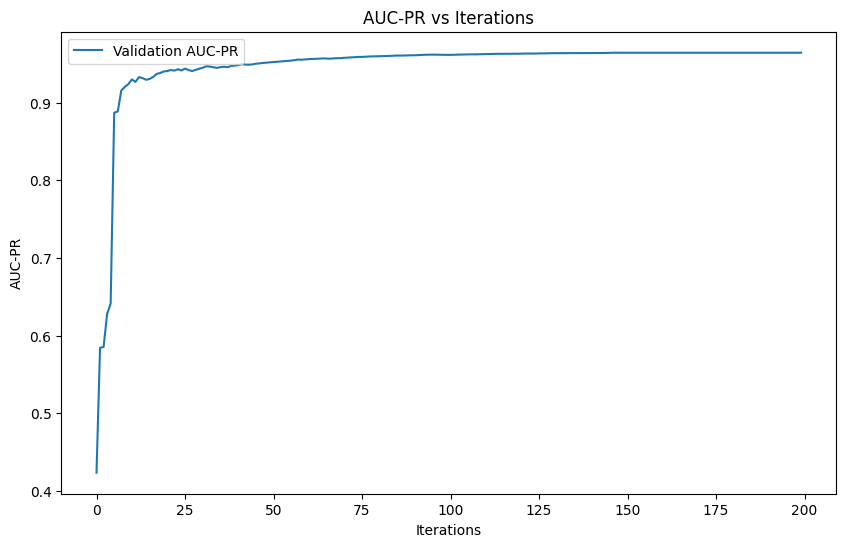

In [147]:
val_aucpr = metrics["validation_0"]["aucpr"]

plt.figure(figsize=(10,6))

plt.plot(val_aucpr, label="Validation AUC-PR")
plt.xlabel("Iterations")
plt.ylabel("AUC-PR")
plt.title("AUC-PR vs Iterations")
plt.legend()


In [141]:
precisions, recalls, thresholds = precision_recall_curve(y_test.to_list(), y_probs)

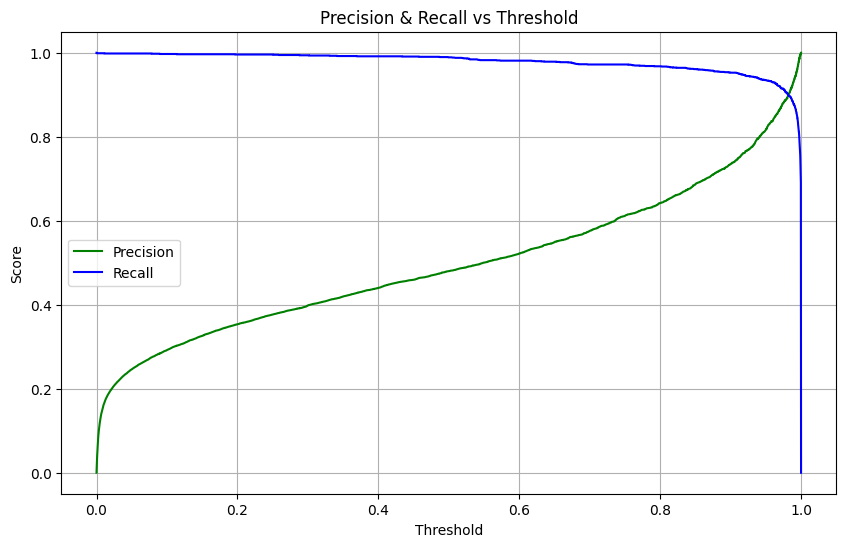

In [148]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='green')
plt.plot(thresholds, recalls[:-1], label='Recall', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [152]:
feature_names[10], feature_names[7], feature_names[9], feature_names[6]

('categorical_vars_type__type_PAYMENT',
 'categorical_vars_type__type_CASH_IN',
 'categorical_vars_type__type_DEBIT',
 'numerical_vars__isFlaggedFraud')

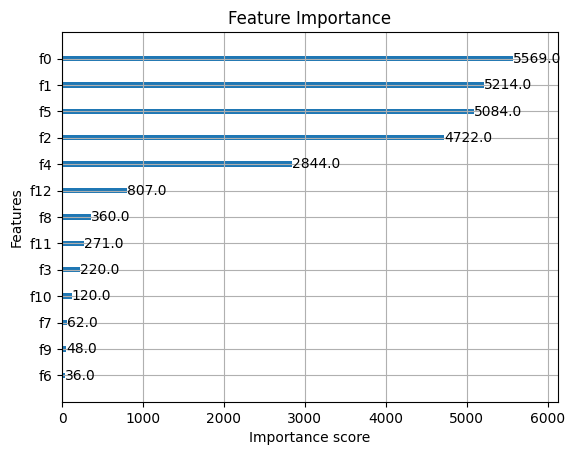

In [150]:
xgb.plot_importance(model, max_num_features=20)
plt.title("Feature Importance")
plt.show()